# Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [2]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0]) # класс число от 0до19 т.к. 20 классов

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [3]:
# Строки - тексты, столбцы - признаки. Две матрицы. Токенизируем
# токенайзер все слова и цифры (регуляркой) длиннее 4 символов 
# переводит в нижний регистр. Принимает строку, отдает список токенов
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


Делаем словарь (только по обучающей подвыборке). Нумеруем токены  

build_vocabulary принимает на вход список списков. Внешний список - датасет, а внутренниие списки - отдельные документы и элементы внутренних списков - это токены в строковом виде.
1. Считаем частоты токенов (через defaultdict)
2. Удаляем очень редкие и очень частые токены
3. Сортируем токены по убыванию частоты, т.е. наиболее часто встречающиеся токены получили наименьшие идентификаторы. Добавляем в список токенов фиктивный токен (В начало), он получит идентификатор 0. 
4. Слов может быть очень много поэтому оставляем только конкретное количество слов
5. Нумеруем слова по порядку сортировки частоты, строим словарь  
Функция возвращает этот словарь и еще вектор весов, содержащий относительные частоты всех токенов в датасете. Пригодится на этапе формирования матрицы признаков

In [4]:
MAX_DF = 0.8 # токены из более чем 80% документов выкидываем
MIN_COUNT = 5 # слова встретившиеся менее 5 раз выкидываем
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10]) # 10 самых частотных токенов
# 20к токенов всего. 

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


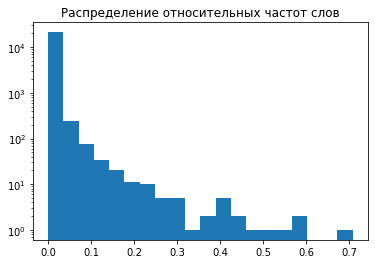

In [5]:
# Проверяем закон Ципфа
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

Токенов, которые встретились хотя бы в половине документов обучающей выборки — очень мало. Токенов, которые встретились хотя бы в 10% обучающей выборки — больше, порядка нескольких сотен. Мода  распределения находится около нуля, то есть большая часть слов (порядка 10000 уникальных токенов) встречаются менее, чем в 5% процентах документов. Закон Ципфа выполняется.



Строим матрицу признаков.  
Vectorize_texts - принимает 3 параметра: список токенизированных текстов (список списков строк), словарь (то есть, отображение из строк в числа) из токенов в их идентификаторы или в их номера, а также вектор, содержащий действительные числа и описывающий относительные частоты токенов. Функция принимает ещё два параметра — именно, это алгоритм взвешивания токенов по частоте (по умолчанию выбран TF-IDF), а также флаг, который говорит, нужно ли перемасштабировать данные после вTкторизации, или не нужно. Сначала мы проверяем, что нам передали режим, с которым мы умеем работать. Далее мы строим прямоугольную матрицу, в которой количество строк соответствует количеству текстов, а количество столбцов соответствует количеству уникальных токенов. Эта матрица будет содержать счётчики: сколько каждый токен встретился в каждом документе. У нас очень мало частых слов — более того, мы их специально выкинули, — матрица счётчиков будет крайне разреженная. Мы можем использовать разреженные матрицы из библиотеки scipy. Разреженные матрицы хранят только ненулевые элементы. Алгоритм подсчёта предельно прост — мы идём по всем текстам, по всем токенам в каждом тексте, и если токен есть в словаре, то мы увеличиваем на единичку соответствующую ячейку матрицы. Если мы получили какой-то неизвестный токен, то, возможно, нам дали либо новые тексты, которых не было в обучающей выборке, либо этот токен был в обучающей выборке, но мы его отфильтровали по частоте. Далее мы реализуем процедуру взвешивания. По умолчанию, в этой функции реализовано 4 алгоритма взвешивания. Первый алгоритм — это бинарные вектора. Этот алгоритм приводит к тому, что матрица весов будет содержать единичку, если токен хотя бы один раз встретился в документе, и нолик, если токена в документе не было. Следующий алгоритм — это относительные частоты слов в документе — TF (term frequency). В этом алгоритме мы сначала преобразовываем матрицу в другой формат разреженных матриц[2]. Формат CSR обеспечивает эффективные операции над строками матриц, но крайне неэффективен для операций над столбцами. Часто выгоднее несколько раз конвертировать матрицу (сначала в один формат, сделать операцию, конвертировать в другой, сделал другую операцию...), чем делать операцию в неподходящем для неё формате. Итак, мы конвертируем в разреженную матрицу для строк и делим каждый счётчик в каждой строке на сумму элементов в этой строке — по сути, мы делим количество употреблений токена в документе на длину этого документа, то есть мы получаем относительную частоту токена в документе. Следующий режим — это IDF (inverse document frequency). Этот алгоритм взвешивания приводит к тому, что, в результирующей матрице признаков, убирается вся информация о частоте токена в документе. Но в этой матрице есть информация о частоте токена в корпусе. Здесь мы сначала получаем матрицу индикаторов (есть ли токен документе, или нет), а затем домножаем индикаторы на вектор весов слов, который мы вычислили на этапе построения словаря. Функция "multiply" реализует операцию поэлементного произведения.[1] Следующий алгоритм объединяет предыдущие два — здесь мы сначала находим TF для каждого токена, а затем домножаем TF на IDF. Всё просто. Ну, и напоследок — мы масштабируем датасет так, чтобы все элементы матрицы укладывались в диапазон от нуля до единицы. Стандартизация входных весов необходима для стабильной работы многих алгоритмов машинного обучения. Способ стандартизации весов зависит от природы данных. Часто используется приведение к нормальному распределению с мат.ожиданием в нуле и единичной дисперсией. Но такой подход нам здесь не подходи.. Потому что у нас матрица разреженная, и если мы сдвинем эту матрицу на её мат.ожидание, то мы получим не разреженную матрицу, и, скорее всего, она у нас для нормального датасета даже в память не влезет. Поэтому мы используем другой способ стандартизации, а именно мин-макс-стандартизацию, то есть мы говорим, что минимально допустимое значение признака в датасете — это 0, а максимально допустимое — это 1. Ну, и напоследок, мы переводим нашу разреженную матрицу в формат, ориентированный на эффективную работу со строками, потому, что алгоритмы машинного обучения, которые мы далее будем использовать, читают документы один за другим и настраивают свои веса, то есть нам нужно уметь эффективно брать отдельный документ. Давайте, например, будем использовать алгоритм TF-IDF. Обращаю ваше внимание, что для векторизации и обучающей, и тестовой выборки, используется один и тот же набор параметров, то есть один и тот же словарь, один и тот же вектор частот и один и тот же режим векторизации.

In [6]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


Давайте посмотрим на характеристики матрицы, которые у нас получились. Количество строк в этих матрицах соответствует количеству примеров в обучающей и в тестовой выборке соответственно, а количество столбцов соответствует количеству уникальных токенов, то есть размеру словаря. А ещё на экране вы видите процент заполненности матриц. Для того, чтобы посчитать, мы взяли количество ненулевых элементов и поделили на полный размер матрицы, то есть на произведение количества строк и количества столбцов. Как видите, в этих матрицах заполнено меньше 0.5% элементов, то есть, используя разреженные матрицы, мы экономим гигантское количество памяти. Давайте, для интереса, посмотрим — как же значения этой матрицы распределены. В принципе, здесь также выполняется закон Ципфа. 



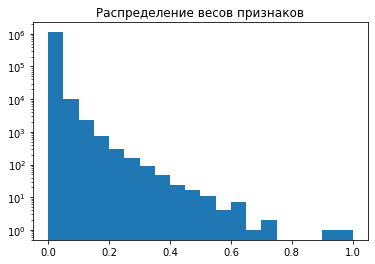

In [7]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

Все значения матрицы лежат строго в диапазоне от нуля до единицы — то чего мы и хотели получить. Давайте теперь проанализируем распределение классов в нашем датасете. 

### Распределение классов

In [8]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


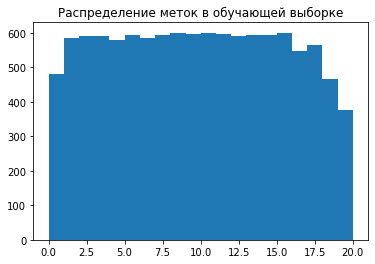

In [9]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

У нас всего 20 классов - классы распределены практически равномерно в обучающей выборке. Да и в тестовой — тоже равномерно. Поэтому, так как классы распределены почти равномерно, мы можем использовать accuracy (или долю правильных предсказаний) как рабочую метрику. Если бы распределение классов было скошенным, эта метрика было бы уже неподходящей, она бы давала сильно завышенные оценки.

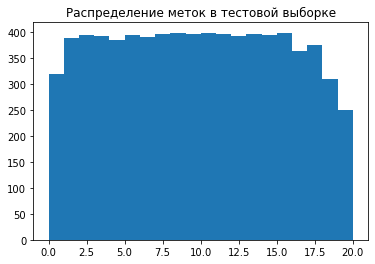

In [10]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

Прежде чем обучить модельку, сначала мы обернём наши матрицы признаков в "Dataset" — это специальная идиома в pytorch, которая призвана повысить удобство подключения различных датасетов, которые могут подгружаться с жёсткого диска, из памяти; загружаться сразу все — в память, или читаться по чуть-чуть. Здесь мы используем "SparseFeaturesDataset". Давайте посмотрим, как он работает. Вот он — это очень простой класс, который принимает на вход в конструктор две матрицы — это матрица признаков, которая разрежена, и матрица меток. По контракту, Dataset должен реализовывать два метода — первый метод "len", он должен возвращать длину датасета, то есть количество примеров в нём, и второй — метод "get item", он должен возвращать один обучающий пример, то есть, в случае нашего семинара — это вектор признаков и метка. Предлагаю вам обратить внимание на то, что "features" — это разреженная матрица, а pytorch не умеет работать с разреженными матрицами. Но, с другой стороны, мы не хотим конвертировать всю матрицу обучающего датасета в плотное представление, потому что у нас памяти не хватит. Поэтому мы храним весь dataset в разреженном виде, но, когда нам нужно выбрать один пример из датасета, мы выбираем только его из разреженной матрицы, конвертируем в плотное представление и заворачиваем в "torch.Tensor". Аналогично поступаем и с метками.

In [11]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

Наша модель — это логистическая регрессия. Логистическая регрессия — это линейная регрессия, выход который сжимается в диапазон от нуля до единицы с помощью логистической функции, то есть сигмоиды. Таким образом, сама модель состоит всего лишь из одного слоя — это линейный слой, у которого количество входов соответствует количеству уникальных токенов, то есть размеру словаря, и количество выходов соответствует количеству меток в датасете. Эту нашу модель мы обучаем с помощью функции "train_eval_loop", которая реализует цикл обучения нейросети. Это функция общего назначения, сюда можно подавать модели не только для классификации, не только текстов, в ней реализованы некоторые стандартные фишки, которые используются при обучении нейросетей. Давайте посмотрим, как она работает. Эта функция принимает целую кучу параметров, но среди этих параметров есть четыре главных — это экземпляр нашей модели, это обучающий датасет, валидационный датасет и наша функция потерь, то есть критерий, минимизируя значение которого мы будем настраивать параметры нашей модели. Что делают остальные параметры — предлагаю пока не рассматривать. Сначала мы переносим нашу модель на то устройство, на котором мы будем производить вычисления — это может быть центральный процессор, либо видеокарта. Затем мы создаём оптимизатор, то есть — говорим, как именно мы должны делать градиентный шаг на каждой итерации. Затем, опционально, мы настраиваем расписание изменения скорости обучения. Менять длину градиентного шага в процессе обучения — это часто хорошая идея, которая приводит к получению лучших значений метрик и функции потерь. Затем мы берём наши Dataset-ы, которые умеют возвращать обучающий пример по индексу (как мы только что рассмотрели), и передаём эти "Dataset" в "DataLoader" — это объект из pytorch, который умеет в многопоточном режиме собирать батчи примеров. В этом семинаре многопоточный режим нам, в принципе, не нужен, но, в общем случае (и в дальнейших семинарах) он вам может пригодиться. Основной смысл использования многопоточного режима — в том, чтобы всегда загружать видеокарты на 100% — таким образом, максимально быстро учить. Далее мы определяем набор переменных, которые позволят нам, в ходе обучения, выбрать лучшую модель. То есть, процесс обучения — стохастический, и модель может как улучшаться в ходе обучения, так и ухудшаться, и не всегда нужно брать последнюю модель. Хорошая практика для выбора лучшей модели в процессе обучения заключается в том, чтобы иметь отложенную выборку, состоящую из некоторого количества примеров, не входящих в обучающих выборку. И, после некоторого количества шагов по обучающей выборке, оценивать качество модели на валидационной выборке (то есть на этой отложенной выборке) и сравнивать качество моделей именно по значениям метрик, вычисленных на отложенной выборке. Далее начинается цикл — обучение состоит из нескольких эпох. Эпоха, в данном случае, носит условный характер — это некоторое количество градиентных шагов. Не обязательно эпоха — это полный проход по датасету. Наша эпоха начинается с того, что мы переводим модель в режим обучения. В данном семинаре это не так важно, но если в нашей нейросети есть такие модули, как dropout или batch norm, критически важно не забывать переводить модель в режим обучения или в режим применения. Далее идёт цикл, реализующий одну эпоху обучения. Мы делаем заданное количество градиентных шагов по обучающей выборке, на каждом шаге мы берём батч примеров — DataLoader нам возвращает уже не отдельные примеры, а целые пачки примеров. Таким образом, в настоящем семинаре, переменная "batch_x" — это прямоугольная матрица, в которой количество строк равно количеству примеров в батче, то есть размеру батча, а количество столбцов — это количество признаков. Мы копируем данные на то же, устройство на котором была и модель, выполняем прямой проход по модели, получаем предсказания, находим значение критерия (то есть значение функции потерь), очищаем оценки градиента с предыдущего шага, находим новое значение градиентов, и делаем градиентный шаг. Также мы запоминаем среднее значение функции потерь на эпохе. Это полезно для мониторинга процесса обучения.

По характеру изменения функции потерь от эпохи к эпохе мы иногда можем понять, что не так с процессом обучения, мы можем увидеть, что модель вообще не сходится или — она очень быстро достигает определённой точки и дальше не учится, или значение функции потерь изменяется практически случайно, с большой дисперсией. Это важный диагностический показатель. Далее мы выводим некоторую полезную информацию, которая говорит нам о том, как именно идёт процесс обучения. Теперь оценим качество модели, переводим модель в режим "eval" (то есть, в режим предсказания) и объявляем переменные для оценки среднего значения функции потерь на отложенной выборке. Далее мы повторяем практически те же самые действия, что и делали при обучении, но не делаем сам градиентный шаг — мы только получаем предсказание модели и оцениваем значение функции потерь. Важный момент, который позволит сэкономить память на видеокарте — это включить режим "torch no_grad". Когда этот режим включён, pytorch не сохраняет промежуточные данные, необходимые для вычисления градиентов. Далее мы сравниваем среднее значение функции потерь на валидации на последней эпохе и лучшее значение функции потерь, полученное аналогичным образом на предыдущих эпохах, и если новое среднее значение функции потерь — лучше, то мы сохраняем текущий вариант модели. Мы делаем это с помощью стандартной функции "copy.deepcopy()". А если улучшить значение функции потерь на отложенной выборке после этой эпохи не получилось, то мы проверяем — а как давно у нас вообще получалось улучшить модель? Если с последней хорошей эпохи прошло уже больше заданного количества эпох, то мы говорим — "ну кажется приехали — кажется, дальше улучшить модель не получится". И, в таком случае, мы прекращаем обучение. Ну, и напоследок — если пользователь задал расписание изменения скорости обучения, то мы обновляем скорость обучения с учётом нового значения функции потерь. Тело этого цикла мы обернули в try-except и добавили обработку двух видов исключений. Первое — это "interrupt", то есть — чтобы пользователь мог досрочно остановить обучение, нажав "Ctrl-C" в Jupyter ноутбуке. И второй обработчик ловит вообще все исключения и печатает их в удобоваримой виде. Вот и всё — наша функция возвращает два объекта. Первый — это лучшее значение функции потерь, а второй объект — это модель с лучшими весами, то есть это веса модели, которые получились после лучшей эпохи (не обязательно, эта эпоха — последняя). 

Во-первых, будем менять длину градиентного шага тогда, когда в течение пяти эпох значение функции потерь на валидации не улучшилось. То есть, если у нас функция потерь вышла на плато,то уменьшаем размер шага, и иногда это позволяет спуститься в более узкие локальные минимумы, которые мы, в противном случае, перепрыгивали бы, и ещё чуть-чуть улучшить значение функции потерь, но это не всегда даёт прирост. В качестве функции потерь мы используем функцию CrossEntropy — это функция из pytorch, она реализует категориальную кросс-энтропию вместе с сигмоидой. Это позволяет нам убрать сигмоиду из самой модели и сделать процесс вычислений чуть более численно стабильным, то есть избежать слишком больших чисел или слишком маленьких. Это должно положительно сказаться на точности вычислений. А также мы задаём здесь длину градиентного шага по умолчанию (то есть "learning rate") как 0.1, говорим, что — максимум, мы будем делать 200 проходов по датасету, то есть 200 эпох, размер батча — это 32, в общем-то и всё. Давайте посмотрим, как оно у нас всё учится. 

In [12]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 1.21 сек
Среднее значение функции потерь на обучении 2.2252603193460883
Среднее значение функции потерь на валидации 2.1137116389759516
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 0.80 сек
Среднее значение функции потерь на обучении 0.9165930989603538
Среднее значение функции потерь на валидации 1.6822081627482075
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 0.84 сек
Среднее значение функции потерь на обучении 0.46601720162704163
Среднее значение функции потерь на валидации 1.4644031009431613
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 0.82 сек
Среднее значение функции потерь на обучении 0.2836355813226457
Среднее значение функции потерь на валидации 1.3450514989889275
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 0.75 сек
Среднее значение функции потерь на обучении 0.19072482339238042
Среднее значение функции потерь на валидации 1.2602526944572643
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 0.79 сек
Среднее значение функции 

На каждой эпохе модель улучшается по валидации. Начиная с 25 эпохи нам не удаётся улучшить модель, поэтому, спустя пять эпох, мы решаем понизить скорость обучения, то есть разделить learning rate на 2. И мы продолжаем обучение с таким learning rate, но, в данном случае, нам это не помогает, и на 35 эпохе мы прекращаем обучение. 

## Оценка качества

Для того, чтобы оценить качество модели, нам нужно взять датасет и предсказать классы для объектов из этого датасета с помощью нашей модели. Для того, чтобы это было делать удобно, мы написали специальную функцию "predict_with_model". Это простая функция, которая принимает на вход модель, датасет, идентификатор устройства (на котором необходимо производить вычисления), размер батча. И, в цикле, идёт по этому датасету, применяет модель и сохраняет результаты в список, а потом этот список преобразовывает в матрицу. Таким образом, на выходе у нас получается матрица, в которой количество строк соответствует количеству элементов в нашем датасете (количеству примеров в нашем датасете), а количество столбцов соответствует количеству классов. Для целей анализа процесса обучения мы вычисляем значение функции потерь на обучающей выборке, а также оцениваем "accuracy", то есть долю верных ответов. Как мы говорили ранее, эта метрика может использоваться только тогда, когда датасет идеально сбалансирован. В противном случае она приводит к завышенной оценке качества работы классификатора. Также мы проделываем все те же действия для валидационной выборки. 



In [13]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:00<00:00, 534.59it/s]


Среднее значение функции потерь на обучении 0.0022322540171444416
Доля верных ответов 0.9994696835778681



236it [00:00, 528.06it/s]                             

Среднее значение функции потерь на валидации 0.928935170173645
Доля верных ответов 0.7681890600106214


Во-первых, мы видим, что обучающую выборку модель практически запомнила — она идеально работает на обучающей выборке. Но на валидационной выборке она даёт верные ответы только в 77% случаев. Значение функции потерь на обучении — порядка нескольких тысячных, а на валидации — почти 1, то есть, значение функции потерь на валидации на два порядка больше, чем значение функции потерь на обучении. Это верный сигнал к тому, что наша модель переобучилась. Но даже, несмотря на такое сильное переобучение, в целом, доля верных ответов не такая плохая.

# Альтернативная реализация на scikit-learn

Давайте теперь посмотрим, как всё то, что мы сейчас описали, реализовать по-быстрому, по простому, с помощью библиотеки scikit-learn. Весь вышеприведённый ноутбук на scikit-learn укладывается всего лишь в 5 строчек — мы задаём параметры алгоритма векторизации текстов, указываем токенизатор, задаём те же параметры для фильтрации токенов по частоте. Говорим, что мы будем использовать логистическую регрессию и обучаем. Давайте посмотрим, какого качества можно достичь с помощью проверенной реализации логистической регрессии.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [15]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.4954788918565254
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.653902258232566
Доля верных ответов 0.8190387679235263


Здесь доля верных ответов на обучающей выборке — поменьше, то есть наша реализация давала accuracy 0.99, реализация scikit-learn даёт 0.96. Но, с другой стороны, на валидации, реализация scikit-learn работает лучше на 4%. Это говорит о том, что модель из scikit-learn переобучилась гораздо меньше. Об этом говорит и гораздо меньший разброс значения функции потерь. Здесь значения функции потерь на обучении и на валидации имеют один порядок и отличаются в первом знаке после запятой.

В качестве домашнего задания можно попробовать сделать:

- изменить способ взвешивания признаков
- реализовать взвешивание признаков с помощью точечной взаимной информации (PMI)
- изменить способ стандартизации данных (см. начиная с 4:25 на шаге 6), например, запоминая сдвиг и масштаб с обучающей выборки и применяя эти параметры для стандартизации тестовой выборки; и/или стандартизируя каждый столбец по отдельности
- добавить регуляризацию
- извлекать признаки не через токены, а через N-граммы
- добавить стемминг или простую лемматизацию
- изменить архитектуру нейросети, например, сделав два слоя вместо одного
- проанализировать, как сильно падает качество классификации с уменьшением размера словаря (для фильтрации словаря можно использовать разные эвристики, например, тот же PMI)  

# Задачи

## 1

Текст -> Результат.  
Контактный телефон: 123123. -> контактный телефон : 123123 .  
Что-нибудь надо придумать.	-> что - нибудь надо придумать .  
Значение числа Е=2.7182.	-> значение числа е = 2.7182 .  
Демон123, как тебя зовут в реале?	-> демон 123 , как тебя зовут в реале ?  
-1-.15=-1.15	-> -1 -.15 = -1.15.   
\- 1 - .15 = -1.15	-> - 1 - .15 = -1.15.  
Какого ;%:?* тут происходит? ->	какого ; % : ? * тут происходит ?

In [ ]:
# Задаем шаблоны в таком порядке: сначала последовательность букв, затем 
# числа с разделителем и возможным знаком минус, 
# потом числа целиком из цифр без разделителя, 
# в конце - непробельный символ.
import re
TOKENIZE_RE = re.compile(r'[а-яё]+|-?\.?\,?\d+\.?\,?\d+|\S', re.I)

tests = {
    'абв123': ['абв', '123'],
    '123абв': ['123', 'абв'],
    '-123абв': ['-123', 'абв'],
    '123.23': ['123.23'],
    '123,23': ['123,23'],
    'Мама мыла -56.035 раму.': ['мама', 'мыла', '-56.035', 'раму', '.'],
    'Мама мыла -56,035 раму.': ['мама', 'мыла', '-56,035', 'раму', '.'],
    'Мама мыла -.035 раму.': ['мама', 'мыла', '-.035', 'раму', '.'],
    'Мама мыла -,035 раму.': ['мама', 'мыла', '-,035', 'раму', '.'],
    'Мама (ну та самая) мыла раму!': ['мама', '(', 'ну', 'та', 'самая', ')', 'мыла', 'раму', '!'],
    'Мама мыла раму.': ['мама', 'мыла', 'раму', '.'],
    'Мама_мыла_раму.': ['мама', '_', 'мыла', '_', 'раму', '.'],
    'Это мама, которая    мыла раму 3раза? Да, всё-таки это - она! Офигеть...': ['это', 'мама', ',', 'которая', 'мыла', 'раму', '3', 'раза', '?', 'да', ',', 'всё', '-', 'таки', 'это', '-', 'она', '!', 'офигеть', '.', '.', '.'],
    'вот такая дробь .52': ['вот', 'такая', 'дробь', '.52'],
    'и вот такая дробь -.52': ['и', 'вот', 'такая', 'дробь', '-.52'],
    'Согласно ст.89 §§ 22-24 и 27 следует...': ['согласно', 'ст', '.89', '§', '§', '22', '-24', 'и', '27', 'следует', '.', '.', '.'],
    'вот такая дробь 0.52': ['вот', 'такая', 'дробь', '0.52'],
    'а это вроде и не дробь 25.': ['а', 'это', 'вроде', 'и', 'не', 'дробь', '25', '.'],          
    'абв абв123 123 .123 -.123 -.123/123 123/1234 -123/1234 1.123 -1.123 123. -123. ..... ,,,,,': \
    ['абв', 'абв', '123', '123', '.123', '-.123', '-.123', '/', '123', 
     '123', '/', '1234', '-123', '/', '1234', '1.123', '-1.123', '123', 
     '.', '-123', '.', '.', '.', '.', '.', '.', ',', ',', ',', ',', ','],
    """Список:
    1. Пункт №1* (со звёздочкой) ;
    2. Пункт второй [#2] 2 < 3 & 2 > 1;
    3.Пункт третий {и последний}""": \
    ['список', ':', '1', '.', 'пункт', '№', '1', '*', '(', 'со', 'звёздочкой',
     ')', ';', '2', '.', 'пункт', 'второй', '[', '#', '2', ']', '2', '<', '3',
     '&', '2', '>', '1', ';', '3', '.', 'пункт', 'третий', '{', 'и', 'последний', '}'],
    '': []
}

def tokenize(txt):
    return TOKENIZE_RE.findall(txt)


for test in tests:
    tokens = tokenize(test.strip().lower())
    try:
        assert tokens == tests[test]
        print(f'{test} - ТЕСТ ПРОЙДЕН')
    except AssertionError:
        print(f'{test} - ТЕСТ ПРОВАЛЕН')
        print('Ожидается:')
        print(tests[test])
        print('Получено:')
        print(tokens)

абв123 - ТЕСТ ПРОЙДЕН
123абв - ТЕСТ ПРОЙДЕН
-123абв - ТЕСТ ПРОЙДЕН
123.23 - ТЕСТ ПРОЙДЕН
123,23 - ТЕСТ ПРОЙДЕН
Мама мыла -56.035 раму. - ТЕСТ ПРОЙДЕН
Мама мыла -56,035 раму. - ТЕСТ ПРОЙДЕН
Мама мыла -.035 раму. - ТЕСТ ПРОЙДЕН
Мама мыла -,035 раму. - ТЕСТ ПРОЙДЕН
Мама (ну та самая) мыла раму! - ТЕСТ ПРОЙДЕН
Мама мыла раму. - ТЕСТ ПРОЙДЕН
Мама_мыла_раму. - ТЕСТ ПРОЙДЕН
Это мама, которая    мыла раму 3раза? Да, всё-таки это - она! Офигеть... - ТЕСТ ПРОЙДЕН
вот такая дробь .52 - ТЕСТ ПРОЙДЕН
и вот такая дробь -.52 - ТЕСТ ПРОЙДЕН
Согласно ст.89 §§ 22-24 и 27 следует... - ТЕСТ ПРОЙДЕН
вот такая дробь 0.52 - ТЕСТ ПРОЙДЕН
а это вроде и не дробь 25. - ТЕСТ ПРОЙДЕН
абв абв123 123 .123 -.123 -.123/123 123/1234 -123/1234 1.123 -1.123 123. -123. ..... ,,,,, - ТЕСТ ПРОЙДЕН
Список:
    1. Пункт №1* (со звёздочкой) ;
    2. Пункт второй [#2] 2 < 3 & 2 > 1;
    3.Пункт третий {и последний} - ТЕСТ ПРОЙДЕН
 - ТЕСТ ПРОЙДЕН


## 2


In [ ]:
from collections import Counter
doclist = ['Казнить нельзя, помиловать. Нельзя наказывать.',
           'Казнить, нельзя помиловать. Нельзя освободить.',
           'Нельзя не помиловать.',
           'Обязательно освободить.',]
word_count = {}
for word in doclist:
    words = [x for x in word.lower().split()]
    words_clean = [x.replace(',','').replace('.','') for x in words]
    for w in words_clean:
        if word_count.get(w):
            word_count[w] += 1
        else:
            word_count[w] = 1

print(word_count)

doc_count = {}
for key in word_count.keys():
    for word in doclist:
        words = [x for x in word.lower().split()]
        words_clean = [x.replace(',','').replace('.','') for x in words]
        if key in words_clean:
            if doc_count.get(key):
                doc_count[key] += 1
            else:
                doc_count[key] = 1
print(doc_count)

DF = dict()
for k,v in doc_count.items():
    DF[k] = v/len(doclist)
print(DF)

answer = sorted(DF.items(), key=lambda x:x[1])
print(answer)
answer_1 = []; 
answer_2 = [];
for k, v in answer:
    answer_1.append(k)
    answer_2.append(str(v))
    
print(" ".join(answer_1))
print(" ".join(answer_2))

{'казнить': 2, 'нельзя': 5, 'помиловать': 3, 'наказывать': 1, 'освободить': 2, 'не': 1, 'обязательно': 1}
{'казнить': 2, 'нельзя': 3, 'помиловать': 3, 'наказывать': 1, 'освободить': 2, 'не': 1, 'обязательно': 1}
{'казнить': 0.5, 'нельзя': 0.75, 'помиловать': 0.75, 'наказывать': 0.25, 'освободить': 0.5, 'не': 0.25, 'обязательно': 0.25}
[('наказывать', 0.25), ('не', 0.25), ('обязательно', 0.25), ('казнить', 0.5), ('освободить', 0.5), ('нельзя', 0.75), ('помиловать', 0.75)]
наказывать не обязательно казнить освободить нельзя помиловать
0.25 0.25 0.25 0.5 0.5 0.75 0.75


## 3 (ver. 1)


In [ ]:
import numpy as np 
from collections import Counter
doclist = ['Казнить нельзя, помиловать. Нельзя наказывать.',
           'Казнить, нельзя помиловать. Нельзя освободить.',
           'Нельзя не помиловать.',
           'Обязательно освободить.',]

doclist_clean = []
for string in doclist:
    string_clean = []
    for word in string.split():
        string_clean += [word.lower().replace(',','').replace('.','') ]
    doclist_clean += [string_clean]
doclist_clean

[['казнить', 'нельзя', 'помиловать', 'нельзя', 'наказывать'],
 ['казнить', 'нельзя', 'помиловать', 'нельзя', 'освободить'],
 ['нельзя', 'не', 'помиловать'],
 ['обязательно', 'освободить']]

In [ ]:
tf = []
for string in doclist_clean:
    word_count = {}
    for w in string:
        if word_count.get(w):
            word_count[w] += 1/len(string)
        else:
            word_count[w] = 1/len(string)
    tf += [word_count]
tf

[{'казнить': 0.2, 'нельзя': 0.4, 'помиловать': 0.2, 'наказывать': 0.2},
 {'казнить': 0.2, 'нельзя': 0.4, 'помиловать': 0.2, 'освободить': 0.2},
 {'нельзя': 0.3333333333333333,
  'не': 0.3333333333333333,
  'помиловать': 0.3333333333333333},
 {'обязательно': 0.5, 'освободить': 0.5}]

In [ ]:
idf_dict = {}
word_set = set([word for sublist in doclist_clean for word in sublist])
for key in word_set:
    strings_number = sum([key in string for string in doclist_clean])
    idf = len(doclist_clean)/strings_number
    idf_dict[key] =  idf
print('idf_dict',end='')
idf_dict

idf_dict

{'обязательно': 4.0,
 'не': 4.0,
 'казнить': 2.0,
 'освободить': 2.0,
 'наказывать': 4.0,
 'нельзя': 1.3333333333333333,
 'помиловать': 1.3333333333333333}

In [ ]:
tfidf = []
for string in tf:
    tfidf_single = {}
    for k in string.keys():
        tfidf_single[k] = np.log(string[k]+1)*idf_dict[k]
    tfidf += [tfidf_single]

tfidf

[{'казнить': 0.3646431135879092,
  'нельзя': 0.4486296488282838,
  'помиловать': 0.2430954090586061,
  'наказывать': 0.7292862271758184},
 {'казнить': 0.3646431135879092,
  'нельзя': 0.4486296488282838,
  'помиловать': 0.2430954090586061,
  'освободить': 0.3646431135879092},
 {'нельзя': 0.38357609660237446,
  'не': 1.1507282898071234,
  'помиловать': 0.38357609660237446},
 {'обязательно': 1.6218604324326575, 'освободить': 0.8109302162163288}]

In [ ]:
mean_dict = {}
for key in word_set:
    sm = 0
    for string in tfidf:
        if string.get(key):
            sm += string.get(key)
    mean_dict[key] = sm/4
mean_dict


{'обязательно': 0.4054651081081644,
 'не': 0.28768207245178085,
 'казнить': 0.1823215567939546,
 'освободить': 0.2938933324510595,
 'наказывать': 0.1823215567939546,
 'нельзя': 0.3202088485647355,
 'помиловать': 0.21744172867989667}

## 3 (ver. 2)

In [ ]:
doclist_clean

[['казнить', 'нельзя', 'помиловать', 'нельзя', 'наказывать'],
 ['казнить', 'нельзя', 'помиловать', 'нельзя', 'освободить'],
 ['нельзя', 'не', 'помиловать'],
 ['обязательно', 'освободить']]

In [ ]:
word_set = sorted(word_set)
word_np = []
for word in word_set:
    word_single = []
    for string in range(len(doclist)):
        word_single_n = 0
        for words in doclist_clean[string]:
            word_single_n += int(word == words)
        word_single += [word_single_n]
    word_np += [word_single]
print(word_set)
word_array = np.array(word_np).T
word_array


['казнить', 'наказывать', 'не', 'нельзя', 'обязательно', 'освободить', 'помиловать']


array([[1, 1, 0, 2, 0, 0, 1],
       [1, 0, 0, 2, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 0]])

In [ ]:
tf = np.divide(word_array,word_array.sum(axis=1).reshape(-1,1))
tf

array([[0.2       , 0.2       , 0.        , 0.4       , 0.        ,
        0.        , 0.2       ],
       [0.2       , 0.        , 0.        , 0.4       , 0.        ,
        0.2       , 0.2       ],
       [0.        , 0.        , 0.33333333, 0.33333333, 0.        ,
        0.        , 0.33333333],
       [0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.5       , 0.        ]])

In [ ]:
print(word_set)
word_in_string = np.array(word_array != 0).astype(int)
print(word_in_string) 
# idf = word_in_string*(1/(word_in_string.sum(axis=0)/word_in_string.shape[0]))
idf = 1/(word_in_string.sum(axis=0)/word_in_string.shape[0])
idf

['казнить', 'наказывать', 'не', 'нельзя', 'обязательно', 'освободить', 'помиловать']
[[1 1 0 1 0 0 1]
 [1 0 0 1 0 1 1]
 [0 0 1 1 0 0 1]
 [0 0 0 0 1 1 0]]


array([2.        , 4.        , 4.        , 1.33333333, 4.        ,
       2.        , 1.33333333])

In [ ]:
ltfidf = np.log(tf+1)*idf
ltfidf

array([[0.36464311, 0.72928623, 0.        , 0.44862965, 0.        ,
        0.        , 0.24309541],
       [0.36464311, 0.        , 0.        , 0.44862965, 0.        ,
        0.36464311, 0.24309541],
       [0.        , 0.        , 1.15072829, 0.3835761 , 0.        ,
        0.        , 0.3835761 ],
       [0.        , 0.        , 0.        , 0.        , 1.62186043,
        0.81093022, 0.        ]])

In [ ]:
ltfidf_mean = ltfidf.mean(axis=0)
ltfidf_mean

array([0.18232156, 0.18232156, 0.28768207, 0.32020885, 0.40546511,
       0.29389333, 0.21744173])

In [ ]:
diff_power = (ltfidf - ltfidf_mean)
std = np.sqrt(np.sum(diff_power**2,axis=0)/(ltfidf.shape[0] - 1))
std

array([0.2105268 , 0.36464311, 0.57536414, 0.21566403, 0.81093022,
       0.38517496, 0.15937143])

In [ ]:
np.set_printoptions(precision=2)
answer = (ltfidf - ltfidf_mean)/std
answer = answer[:,[1,2,4,0,5,3,6]]
print(answer)


# 1.5  -0.5 -0.5 0.87 -0.76 0.60 0.16
# -0.5 -0.5 -0.5 0.87 0.18  0.60 0.16

for string in answer:
    print(' '.join([str(round(x,2)) for x in string]))

[[ 1.5  -0.5  -0.5   0.87 -0.76  0.6   0.16]
 [-0.5  -0.5  -0.5   0.87  0.18  0.6   0.16]
 [-0.5   1.5  -0.5  -0.87 -0.76  0.29  1.04]
 [-0.5  -0.5   1.5  -0.87  1.34 -1.48 -1.36]]
1.5 -0.5 -0.5 0.87 -0.76 0.6 0.16
-0.5 -0.5 -0.5 0.87 0.18 0.6 0.16
-0.5 1.5 -0.5 -0.87 -0.76 0.29 1.04
-0.5 -0.5 1.5 -0.87 1.34 -1.48 -1.36
